In [1]:
# import os
# os.chdir('/Users/evanli/Documents/EvanPys/Progress/')

# from ADlasso2 import AD2_w_utils as ad
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
import scipy
import sklearn
import copy
import importlib


In [2]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve, auc


In [3]:
import scanpy as sc
import scvelo as scv

# data = sc.read('/home/evanlee/PBMC_Hao/Hao_PBMC_level1_rep_cells.h5ad')
data = sc.read('/Users/evanli/Documents/Research_datasets/PBMC_Hao/Hao_PBMC.h5ad')
data.shape

(161764, 20568)

In [4]:
data.shape

(161764, 20568)

In [5]:
# CPM
sc.pp.normalize_total(data, target_sum=1e6)

# log1p
sc.pp.log1p(data)

In [6]:
data.obs['celltype.l1'] = data.obs['celltype.l1'].str.replace(' ', '_')

label = data.obs['celltype.l1'].tolist()
types = np.unique(label).tolist()
# types = [s.replace(' ', '_') for s in types]
types

['B', 'CD4_T', 'CD8_T', 'DC', 'Mono', 'NK', 'other', 'other_T']

In [7]:
import os
os.chdir('/Users/evanli/Documents/EvanPys/Progress/PBMC_Hao/Remove_pvl0_v3_ttsplit/lambda_decision_ignore_section/v3_feature_selection')

features_dict = {}
# Read features for each celltype
for celltype in types:
    try:
        feature_df = pd.read_csv(f'{celltype}_features.txt', names=['Gene', 'Weight', 'Tendency'], sep='\t')
        features_dict[celltype] = feature_df
    except:
        print('skipping:', celltype)
        continue
    print(celltype, 'Feature count:', feature_df.shape[0])
    print(celltype, 'Positive feature count:', feature_df[feature_df['Tendency'] == 1].shape[0])
    print('------------------')

B Feature count: 17
B Positive feature count: 9
------------------
CD4_T Feature count: 1786
CD4_T Positive feature count: 36
------------------
CD8_T Feature count: 26
CD8_T Positive feature count: 9
------------------
DC Feature count: 19
DC Positive feature count: 10
------------------
Mono Feature count: 18
Mono Positive feature count: 11
------------------
NK Feature count: 28
NK Positive feature count: 15
------------------
other Feature count: 5
other Positive feature count: 4
------------------
other_T Feature count: 76
other_T Positive feature count: 28
------------------


### B cells: k-fold CV

In [24]:
celltype = 'B'

# subset data to celltype features
X = data[:, features_dict[celltype]['Gene'].tolist()].X  # 17 features for B cells
# Binary label
y = [1 if i==celltype else 0 for i in data.obs['celltype.l1'].tolist()]

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

print(X_train.shape)
print(X_test.shape)
print(len(y_train))
print(len(y_test))

(129411, 17)
(32353, 17)
129411
32353


In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, cross_validate, KFold

clf = LogisticRegression(penalty='l2', solver='lbfgs', C=1.0)
clf.fit(X_train, y_train)

# Kfold cross validation
scoring = {
    'accuracy': 'accuracy',
    'precision': 'precision',
    'f1_score': 'f1',
    'roc_auc': 'roc_auc'
}

cv_results = cross_validate(clf, X, y, cv=5, scoring=scoring)

In [11]:
cv_results

{'fit_time': array([0.54071522, 0.53153896, 0.45986104, 0.46070814, 0.44732213]),
 'score_time': array([0.04089499, 0.03820014, 0.03923988, 0.038378  , 0.03817487]),
 'test_accuracy': array([0.99882546, 0.99876364, 0.99925818, 0.99932   , 0.99941271]),
 'test_precision': array([0.99454942, 0.99382716, 0.99457701, 0.99637418, 0.99782056]),
 'test_f1_score': array([0.99310595, 0.99274574, 0.99565689, 0.99601305, 0.9965536 ]),
 'test_roc_auc': array([0.99975027, 0.99971922, 0.99994445, 0.9999373 , 0.99997354])}

In [13]:
print("Accuracy: ", np.mean(cv_results['test_accuracy']))
print("Precision: ", np.mean(cv_results['test_precision']))
print("F1 Score: ", np.mean(cv_results['test_f1_score']))
print("ROC AUC: ", np.mean(cv_results['test_roc_auc']))

Accuracy:  0.9991159979767575
Precision:  0.995429665837454
F1 Score:  0.9948150464480563
ROC AUC:  0.9998649576035007


In [36]:
# Use KFold()
clf = LogisticRegression(penalty='l2', solver='lbfgs', C=1.0)
clf.fit(X_train, y_train)

k = 5
kf = KFold(n_splits=k, shuffle=True, random_state=0)

# Perform k-fold cross-validation with multiple metrics
cross_val_results = cross_validate(clf, X, y, cv=kf, scoring=scoring)

print("Accuracy: ", np.mean(cross_val_results['test_accuracy']))
print("Precision: ", np.mean(cross_val_results['test_precision']))
print("F1 Score: ", np.mean(cross_val_results['test_f1_score']))
print("ROC AUC: ", np.mean(cross_val_results['test_roc_auc']))

Accuracy:  0.9991407238669691
Precision:  0.9958739829063852
F1 Score:  0.9949598453197387
ROC AUC:  0.9998703892299222


In [37]:
from sklearn.model_selection import StratifiedKFold
# Use StratifiedKFold()
clf = LogisticRegression(penalty='l2', solver='lbfgs', C=1.0)
clf.fit(X_train, y_train)

k = 5
skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=0)

# Perform k-fold cross-validation with multiple metrics
cross_val_results = cross_validate(clf, X, y, cv=skf, scoring=scoring)

print("Accuracy: ", np.mean(cross_val_results['test_accuracy']))
print("Precision: ", np.mean(cross_val_results['test_precision']))
print("F1 Score: ", np.mean(cross_val_results['test_f1_score']))
print("ROC AUC: ", np.mean(cross_val_results['test_roc_auc']))

Accuracy:  0.9991407227204915
Precision:  0.9959340996740178
F1 Score:  0.9949581993950355
ROC AUC:  0.9998688063863558


## K-fold CV for all celltypes (all features)

In [14]:
def LR_kfold(data, all_features_dict, celltype, k=5):
    # subset data to celltype features
    X = data[:, features_dict[celltype]['Gene'].tolist()].X
    # Binary label
    y = [1 if i==celltype else 0 for i in data.obs['celltype.l1'].tolist()]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

    clf = LogisticRegression(penalty='l2', solver='lbfgs', C=1.0)
    clf.fit(X_train, y_train)

    # Kfold cross validation
    scoring = {
        'accuracy': 'accuracy',
        'precision': 'precision',
        'f1_score': 'f1',
        'roc_auc': 'roc_auc'
    }
    cv_results = cross_validate(clf, X, y, cv=5, scoring=scoring)

    mean_accuracy = np.mean(cv_results['test_accuracy'])
    mean_precision = np.mean(cv_results['test_precision'])
    mean_f1 = np.mean(cv_results['test_f1_score'])
    mean_auc = np.mean(cv_results['test_roc_auc'])
    mean_metrics = [mean_accuracy, mean_precision, mean_f1, mean_auc]

    return mean_metrics

In [15]:
types

['B', 'CD4_T', 'CD8_T', 'DC', 'Mono', 'NK', 'other', 'other_T']

In [19]:
os.chdir('/Users/evanli/Documents/EvanPys/Progress/PBMC_Hao/Remove_pvl0_v3_ttsplit/lambda_decision_ignore_section/classifiers/Kfold')

all_metrics = pd.DataFrame(columns=['Accuracy', 'Precision', 'F1-score', 'ROC-AUC'])
for celltype in types:
    print('====================')
    print('K-fold CV for:', celltype)
    metrics = LR_kfold(data, features_dict, celltype, k=5)  # metrics is a list
    print(metrics)
    all_metrics = pd.concat([all_metrics, pd.DataFrame([metrics], columns=['Accuracy', 'Precision', 'F1-score', 'ROC-AUC'])], axis=0)


K-fold CV for: B
[0.9991159979767575, 0.995429665837454, 0.9948150464480563, 0.9998649576035007]
K-fold CV for: CD4_T
[0.9600962365101248, 0.9223411506967206, 0.9218422640724426, 0.9918969459337325]
K-fold CV for: CD8_T
[0.9709453453363113, 0.9204581377681059, 0.906245404916155, 0.9899107717934228]
K-fold CV for: DC
[0.9966679859948137, 0.9311382304175353, 0.9243836854219708, 0.9985043247574723]
K-fold CV for: Mono
[0.9894043162143445, 0.9735691316568916, 0.9826792304762508, 0.9976218842933884]
K-fold CV for: NK
[0.9919944998198196, 0.9661188794170608, 0.9653304879140837, 0.9987098660623005]
K-fold CV for: other
[0.9897875991362959, 0.7961741180917278, 0.7348319869543268, 0.8915122382760341]
K-fold CV for: other_T
[0.9810340836921885, 0.8379646368272999, 0.7504139737632867, 0.9810332167478627]


In [21]:
all_metrics.index = types
all_metrics

,Accuracy,Precision,F1-score,ROC-AUC
B,0.999116,0.995430,0.994815,0.999865
CD4_T,0.960096,0.922341,0.921842,0.991897
CD8_T,0.970945,0.920458,0.906245,0.989911
DC,0.996668,0.931138,0.924384,0.998504
Mono,0.989404,0.973569,0.982679,0.997622
NK,0.991994,0.966119,0.965330,0.998710
other,0.989788,0.796174,0.734832,0.891512
other_T,0.981034,0.837965,0.750414,0.981033


In [22]:
all_metrics.to_csv('Kfold_metrics.csv')

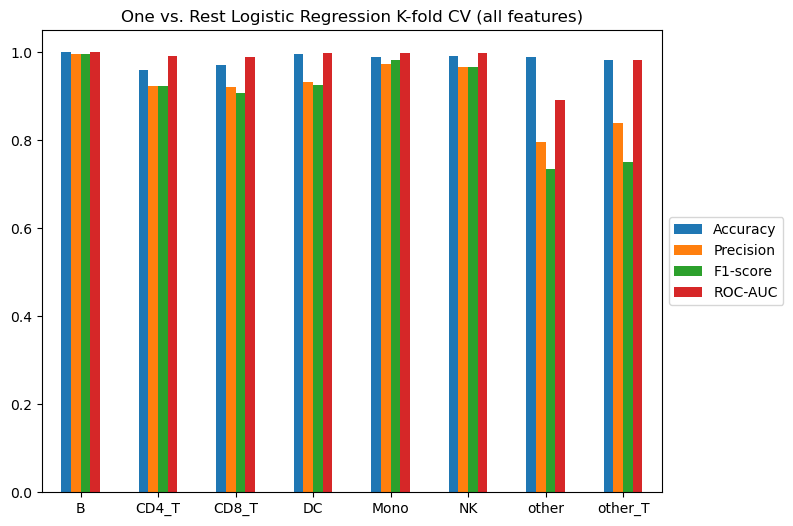

In [23]:
# Plot metrics for each celltype
ax = all_metrics.plot.bar(rot=0, figsize=(8,6), title='One vs. Rest Logistic Regression K-fold CV (all features)')
ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))